# Teen mental health and social media – Back of the envelope calculations
Major depressive episodes among teen girls have increased by 52% since 2005 ([Twenge, et al. 2020](https://prcp.psychiatryonline.org/doi/10.1176/appi.prcp.20190015)). Many reseachers believe social media is the primary cause ([Haidt & Twenge](https://docs.google.com/document/d/1w-HOfseF2wF9YIpXwUUtP65-olnkPyWcgF5BiAtBEy0/edit)).

Other researchers do not believe that social media is the cause, since the correlations between social media use and well-being are thought to be small. The correlation between overall screen time and well-being is -0.05. When narrowing down to social media and girls, the correlation is -0.17. Some researchers describe these correlations as "so minimal that they hold little practical value". ([Orben & Przybylski, 2019](https://files.de-1.osf.io/v1/resources/q7pr4/providers/osfstorage/5de76058e1e62f000c37365c?action=download&version=1&direct)). 

In this notebook, I use a simple linear+threshold model and back-of-the-envelope calculations to show that these correlations are not small and are in fact of significant practical importance. In particular, the -0.17 correlation for teen girls is enough to explain the 52% increase in depression since 2005. 

### Basic overview
My model makes the simplest possible assumptions. 
* Well-being is normally distributed. (The scale doesn't matter)
* Social media use per day averages 2 hours with a light rightward skew in the distribution. (Scale doesn't matter)
* Well-being is a linear function of social media use.
* Depression occurs when well-being falls below a threshold. The threshold was chosen to fit the baseline depression rate before social media.

### Results
Using the simple linear+threshold model, a correlation of 0.17 would increase depression rates in girls from a baseline of 13% to a new value 19%, which is almost the same value observed in [Twenge, et al. (2020)](https://prcp.psychiatryonline.org/doi/10.1176/appi.prcp.20190015). 

The intuition is that a small increase in a correlation can cause a large _relative_ change in the percentage of tail points that exceed a threshold.

In boys, the correlation between social media and well being is much weaker, and the model correctly predicts a much smaller increase rates of depression. 


### Commentary on the assumptions
The purpose of this model is not to precisely describe the relationship between social media and well-being. Rather it is meant to serve as a back-of-the-envelope response to claims that small correlations cannot possibly explain large increases in depression. As this model shows, they can.

If one wishes, the model's assumptions could be further refined, which would variously strengthen or weaken the size of the effect.
* Allowing noise in depression diagnoses, rather than a hard threshold, would weaken the effect.
* Adding [nonlinearities](https://doi.org/10.1038/s41562-020-0839-4) would strengthen the effect.
* Adding [network effects](https://chris-said.io/2021/08/14/teens-loneliness-social-media/) would strengthen the effect.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import pandas as pd

blue='#3ac3f2'
pink='#ed2685'
gray='#aaaaaa'
orange='#f58032'

In [4]:
path = '/Users/chrissaid/Dropbox/Blogs and Blog Material/csaid.github.io/assets/2022_teen_depression_and_social_media'

In [5]:
def rs_corr(x, baseline_scores, hours, target_r):
    # Returns the root squared difference between a candidate correlation and target correlation
    slope = x[0]
    new_scores = baseline_scores + slope * hours
    actual_r = np.corrcoef(hours, new_scores)[0,1]
    return np.sqrt((actual_r - target_r)**2)

In [46]:
def plot_bars(stats, sex, color):
    plt.figure(figsize=[6,3])
    plt.bar([0], [stats[sex]['depr_rate_t1_actual']*100], color=gray)
    plt.bar([1], [stats[sex]['depr_rate_t2_actual']*100], color=color)
    plt.bar([2], [stats[sex]['depr_rate_t2_predicted']*100], color=color, alpha=0.5)
    plt.ylim([0, 25])
    plt.ylabel('Depression rate (%)', fontsize=14)
    plt.yticks(fontsize=12)
    plt.xticks([0, 1, 2], ['Pre Social Media', 'Social Media\n(Actual)', 'Social Media\n(Predicted)'], fontsize=12);
    sns.despine()
    plt.tight_layout()

In [6]:
n = 500000

#### Assumptions about hours of social media per day
My results are fairly robust to reasonable changes to the shape and size of this distribution.

In [23]:
mean_hours = 2
scale = 2
hours = np.random.gamma(scale, mean_hours/scale, size=n)

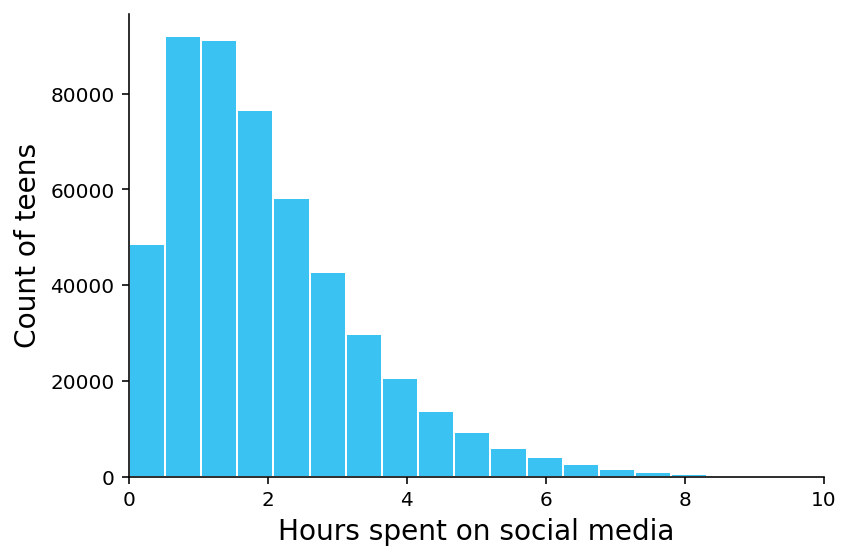

In [24]:
plt.hist(hours, bins=30, facecolor=blue, edgecolor='w');
plt.xlim([0, 10])
plt.xlabel('Hours spent on social media', fontsize=14)
plt.ylabel('Count of teens', fontsize=14)
sns.despine()
plt.tight_layout()
plt.savefig(path+'/fig_hours.png', dpi=150)

## Create well-being distributions; and fit a slope and threshold to known data

In [25]:
def get_stats(depr_rate_t1_actual, depr_rate_t2_actual, r_actual):
    scores_t1 = np.random.randn(n)
    initial_guess = -0.1
    
    # find the well-being score per hour slope that reproduces the actual correlation
    slope = minimize(rs_corr, [initial_guess], args=(scores_t1, hours, r_actual)).x[0]

    scores_t2 = scores_t1 + slope * hours
    r_reproduced = np.corrcoef(hours, scores_t2)[0,1]

    cutoff = np.percentile(scores_t1, depr_rate_t1_actual * 100)
    depr_rate_t1_predicted = (scores_t1<cutoff).mean()    
    depr_rate_t2_predicted = (scores_t2<cutoff).mean()

    assert np.isclose(r_reproduced, r_actual) # confirm I picked the right slope
    assert np.isclose(depr_rate_t1_actual, depr_rate_t1_predicted) # confirm I picked the right score cutoff

    return {
        'hours': hours,
        'scores_t1': scores_t1,
        'scores_t2': scores_t2,
        'slope': slope,
        'cutoff': cutoff,
        'depr_rate_t1_actual': depr_rate_t1_actual,
        'depr_rate_t2_actual': depr_rate_t2_actual,
        'depr_rate_t2_predicted': depr_rate_t2_predicted,
        'relative_increase_actual': depr_rate_t2_actual / depr_rate_t1_actual,
        'relative_increase_predicted': depr_rate_t2_predicted / depr_rate_t1_actual,
    }

In [26]:
stats = {}

### Girls

In [30]:
sex = 'girls'
depr_rate_t1_actual = 0.131 # Twenge (2019) Journal of Psychopathology and Clinical Science
depr_rate_t2_actual = 0.199 # Twenge (2019) Journal of Psychopathology and Clinical Science
r_actual = -0.17 # correlation reported in Twenge et al. (2020) Nature Human Behavior

In [31]:
stats[sex] = get_stats(depr_rate_t1_actual, depr_rate_t2_actual, r_actual)
print(f"Depression rates at baseline: {stats[sex]['depr_rate_t1_actual']:.3f}")
print(f"Depression rates with social media: {stats[sex]['depr_rate_t2_predicted']:.3f}")

Depression rates at baseline: 0.131
Depression rates with social media: 0.193


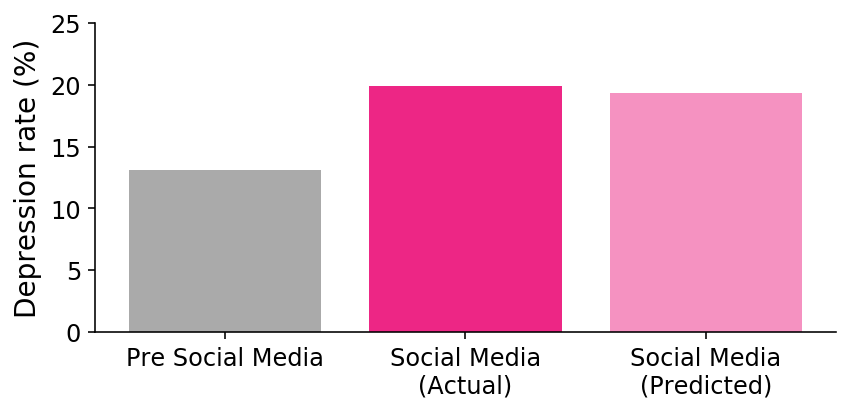

In [48]:
plot_bars(stats, 'girls', pink)
plt.savefig(path+'/fig_bars.png', dpi=150)

### Boys

In [27]:
sex = 'boys'
depr_rate_t1_actual = 0.043 # Twenge (2019) Journal of Psychopathology and Clinical Science
depr_rate_t2_actual = 0.065 # Twenge (2019) Journal of Psychopathology and Clinical Science
r_actual = -0.07 # correlation reported in Twenge et al. (2020) Nature Human Behavior

In [28]:
stats[sex] = get_stats(depr_rate_t1_actual, depr_rate_t2_actual, r_actual)
print(f"Depression rates at baseline: {stats[sex]['depr_rate_t1_actual']:.3f}")
print(f"Depression rates with social media: {stats[sex]['depr_rate_t2_predicted']:.3f}")

Depression rates at baseline: 0.043
Depression rates with social media: 0.054


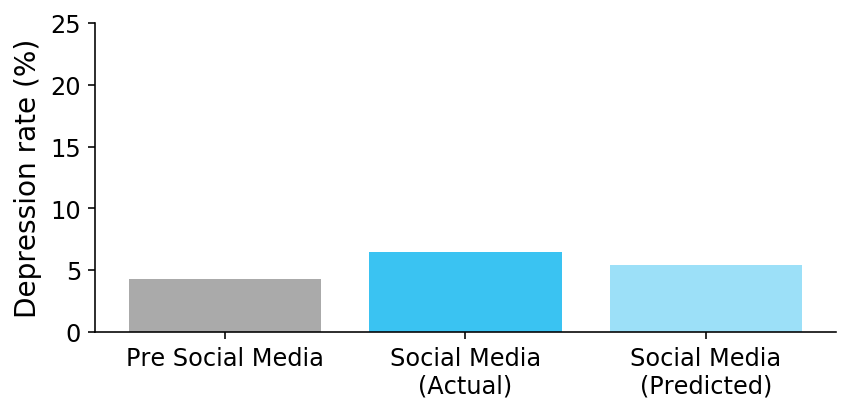

In [47]:
plot_bars(stats, 'boys', blue)

# Plots
Only showing results for girls

In [14]:
df = pd.DataFrame({
    'baseline_score': stats['girls']['scores_t1'],
    'new_score': stats['girls']['scores_t2'],
    'hours': stats['girls']['hours'],
}).sample(3000) # downsample so plots are less crowded
cutoff = stats['girls']['cutoff']


In [15]:
mx_hours = 11
mx_score = max(df['baseline_score'].max(), df['new_score'].max()) * 1.35
mn_score = min(df['baseline_score'].min(), df['new_score'].min()) * 1.05

In [16]:
def make_scatter(df, ycolumn, ylabel='Well-being', slope=0, title=' '):
    plt.scatter(df['hours'], df[ycolumn], label='Not depressed', color=gray, s=10)
    plt.scatter(df['hours'][df[ycolumn]<cutoff], df[ycolumn][df[ycolumn]<cutoff], label='Depressed', color=orange, s=10)
    plt.xlabel('Hours spent on social media', fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.plot([0, mx_hours], [0, slope * mx_hours], color='k')
    plt.title(title, fontsize=20)
    plt.ylim([mn_score, mx_score]) 
    plt.xlim([plt.xlim()[0], mx_hours]) 
    plt.legend(loc='upper right')


### Side-by-side plot

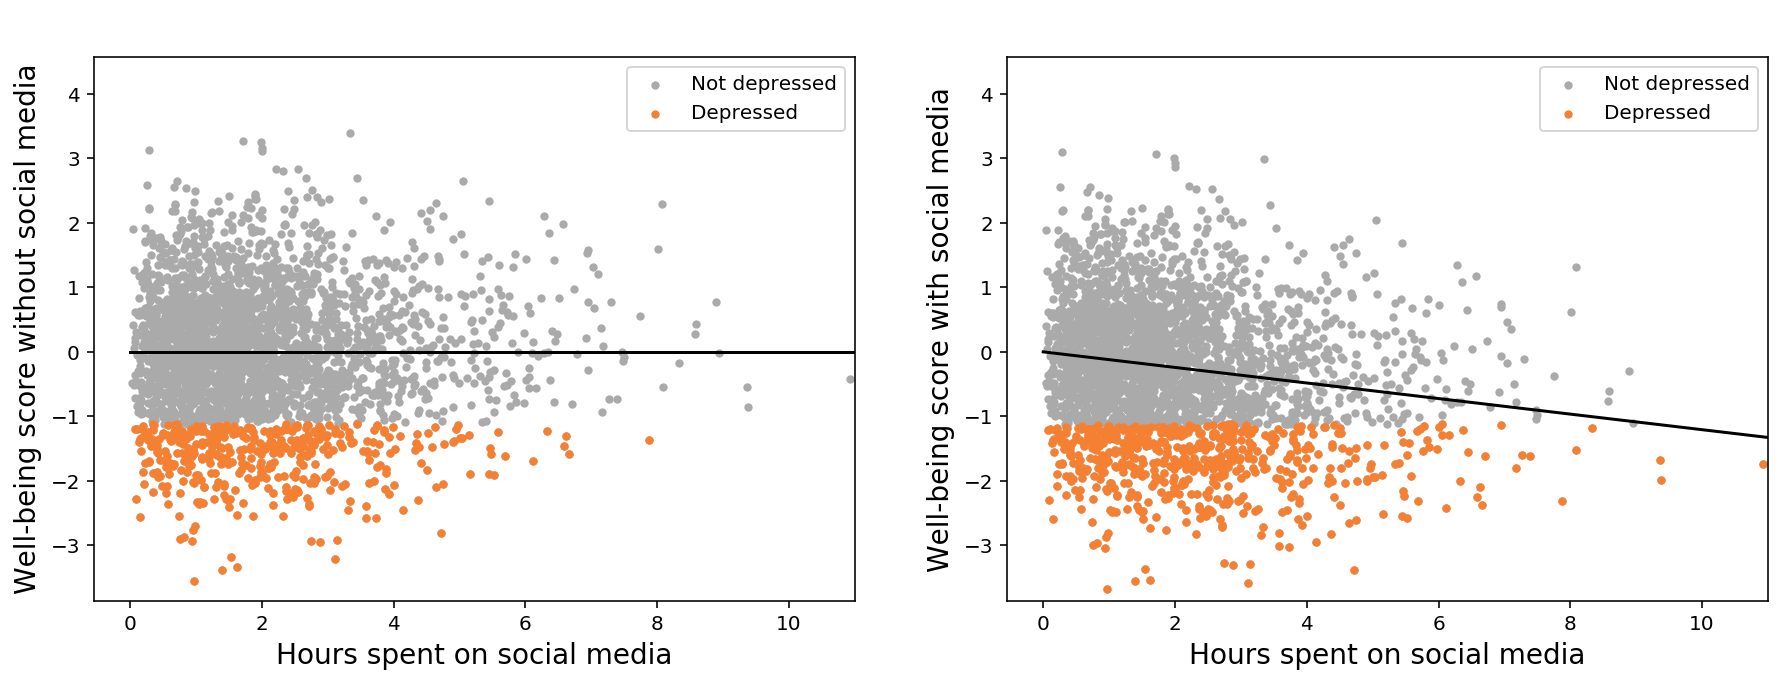

In [17]:
fig, axes = plt.subplots(1, 2, figsize=[15, 5])
plt.sca(axes[0])
make_scatter(df, 'baseline_score', ylabel='Well-being score without social media', slope=0)
plt.sca(axes[1])
make_scatter(df, 'new_score', ylabel='Well-being score with social media', slope=stats['girls']['slope'])

### Animation
Can create a GIF with ImageMagick
```
convert -delay 3 -loop 0 frames/frame*.png animation.gif
```

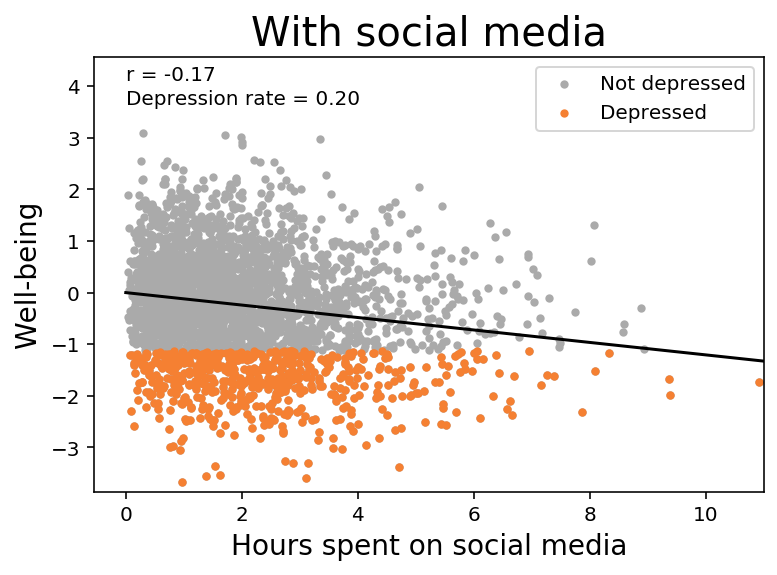

In [18]:
girls_slope = stats['girls']['slope']
slopes = np.concatenate([45*[0], np.linspace(0, girls_slope, 60), 45*[girls_slope]])
plt.figure()
for frame_idx, slope in enumerate(slopes):
    if slope == 0:
        title = 'Without social media'
    elif slope == girls_slope:
        title = 'With social media'
    else:
        title = ' '
    plt.gca().clear()
    df['new_score'] = df['baseline_score'] + slope * df['hours']
    make_scatter(df, 'new_score', ylabel='Well-being', slope=slope, title=title)
    r = df[['hours', 'new_score']].corr().loc['hours', 'new_score']
    dep_rate = (df['new_score'] < cutoff).mean()
    plt.text(0, mx_score * 0.90, f'r = {r:.2f}')
    plt.text(0, mx_score * 0.80, f'Depression rate = {dep_rate:.2f}')
    plt.savefig(f'frames/frame_{frame_idx:03d}.png', dpi=200)